In [1]:
import torch
from torch import nn 
import numpy as np
import matplotlib.pyplot as plt

from utils import ray_generator, plot_rays
from model import Sphere
from rendering import rendering
from loss import mse_loss, mse2psnr

In [2]:
#constants
HEIGHT = 400
WIDTH = 400
FOCUS = 1200

tn = 0.8
tf = 1.2

ORIGIN = [0., 0., -1.]
RADIUS = [.1]
learning_rate = 2e-1

color = [0., 1., 1.] #cyan
target_color = [1., 0., 1.] #purple

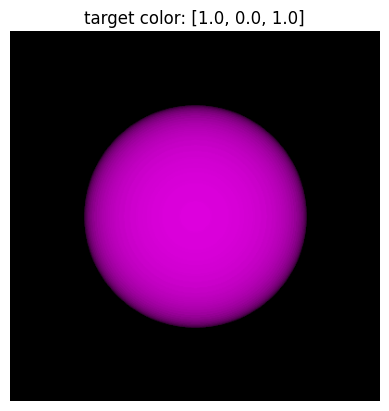

In [3]:
rays_origin , rays_direction = ray_generator(HEIGHT, WIDTH, FOCUS)

target_sphere = Sphere(torch.tensor(ORIGIN), torch.tensor(RADIUS), torch.tensor(target_color))
target_px_colors = rendering(target_sphere, torch.tensor(rays_origin), torch.tensor(rays_direction), 0.8, 1.2, white_background=False)

target_img = target_px_colors.reshape(HEIGHT, WIDTH, 3).cpu().numpy()
plt.title(f"target color: {target_color}")
plt.axis(False)
plt.imshow(target_img)
plt.savefig('images/target_sphere.jpg', bbox_inches = 'tight')

In [4]:
color_to_optimize = torch.tensor(color, requires_grad = True, dtype = torch.float32)
optimizer = torch.optim.SGD(params={color_to_optimize}, lr=learning_rate)

/home/stanley/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


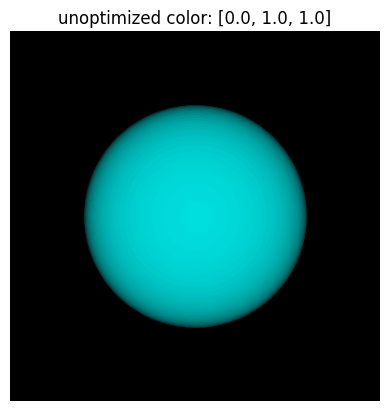

In [5]:
unoptim_sphere = Sphere(torch.tensor(ORIGIN), torch.tensor(RADIUS), color_to_optimize)
unoptim_px_colors = rendering(unoptim_sphere, torch.tensor(rays_origin), torch.tensor(rays_direction), 0.8, 1.2, white_background=False)
unoptim_img = unoptim_px_colors.reshape(HEIGHT, WIDTH, 3).data.cpu().numpy()
plt.title(f"unoptimized color: {color}")
plt.axis(False)
plt.imshow(unoptim_img)
plt.savefig(f'images/unoptimized_sphere.jpg', bbox_inches = 'tight')

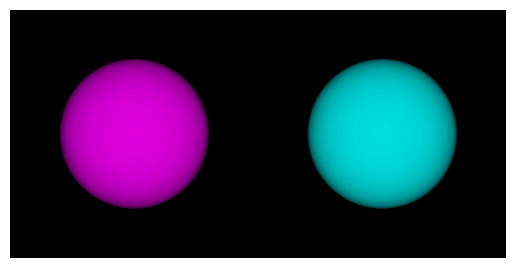

In [6]:
concat_image = np.hstack((target_img, unoptim_img))
plt.axis(False)
plt.imshow(concat_image)

loss: 0.0987
color: [0.0197, 0.9803, 1.0]
loss: 0.0663
color: [0.197, 0.803, 1.0]
loss: 0.0445
color: [0.3422, 0.6578, 1.0]
loss: 0.0298
color: [0.4611, 0.5389, 1.0]
loss: 0.0200
color: [0.5586, 0.4414, 1.0]
loss: 0.0134
color: [0.6384, 0.3616, 1.0]
loss: 0.0090
color: [0.7038, 0.2962, 1.0]
loss: 0.0061
color: [0.7573, 0.2427, 1.0]
loss: 0.0041
color: [0.8012, 0.1988, 1.0]
loss: 0.0027
color: [0.8371, 0.1629, 1.0]
loss: 0.0018
color: [0.8666, 0.1334, 1.0]
loss: 0.0012
color: [0.8907, 0.1093, 1.0]
loss: 0.0008
color: [0.9105, 0.0895, 1.0]
loss: 0.0006
color: [0.9267, 0.0733, 1.0]
loss: 0.0004
color: [0.9399, 0.0601, 1.0]
loss: 0.0002
color: [0.9508, 0.0492, 1.0]
loss: 0.0002
color: [0.9597, 0.0403, 1.0]
loss: 0.0001
color: [0.967, 0.033, 1.0]
loss: 0.0001
color: [0.9729, 0.0271, 1.0]
loss: 0.0001
color: [0.9778, 0.0222, 1.0]


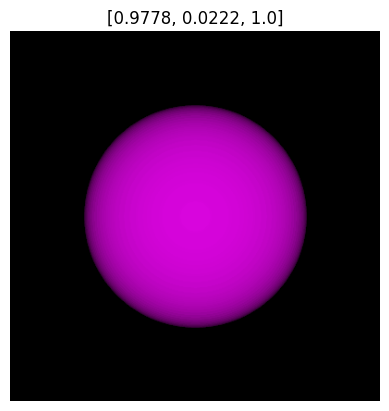

In [7]:
losses = []
for epoch in range(200):
    #using helper functions without print statements
    s = Sphere(torch.tensor(ORIGIN), torch.tensor(RADIUS), color_to_optimize)
    Ax = rendering(s, torch.tensor(rays_origin),torch.tensor(rays_direction), 0.8, 1.2, white_background=False)


    loss = ((Ax - target_px_colors)**2).mean()
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        current_color = [round(color, 4) for color in color_to_optimize.data.tolist()]
        print(f"loss: {loss:.4f}")
        print(f"color: {current_color}")
        
        
        img = Ax.reshape(HEIGHT, WIDTH, 3).cpu().data.numpy()
        plt.title(f"{current_color}")
        plt.axis(False)
        plt.imshow(img)
        # plt.show()
        plt.savefig(f'sphere_img/sphere_epoch_{str(epoch)}.jpg', bbox_inches='tight')
    

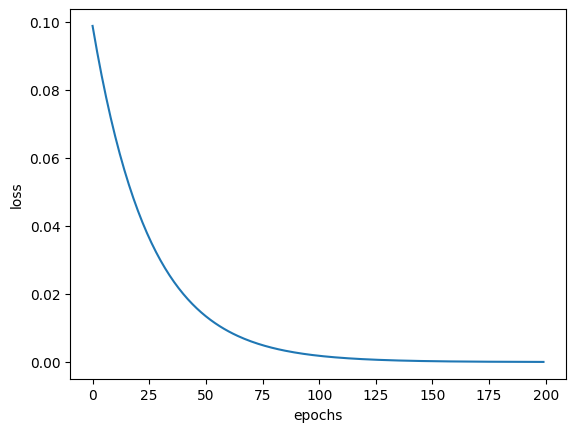

In [9]:
plt.plot(losses)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig(f'images/sphere_loss.jpg', bbox_inches = 'tight')

In [ ]:
import json
with open('outputs/sphere_losses.json', 'r') as file:
    t_losses = json.dump(file)

In [ ]:
losses = []
for epoch in range(200):
    #using helper functions without print statements
    s = Sphere(torch.tensor(ORIGIN), torch.tensor(RADIUS), color_to_optimize)
    Ax = rendering(s, torch.tensor(rays_origin),torch.tensor(rays_direction), 0.8, 1.2, white_background=False)


    loss = ((Ax - target_px_colors)**2).mean()
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        current_color = [round(color, 4) for color in color_to_optimize.data.tolist()]
        print(f"loss: {loss:.4f}")
        print(f"color: {current_color}")
        
        
        img = Ax.reshape(HEIGHT, WIDTH, 3).cpu().data.numpy()
        fig, axs = plt.subplots(1,2, figsize=(20,9))
        axs[0].imshow(img)
        axs[0].set_title(f"{current_color}")
        axs[0].axis(False)
        
        axs[1].plot(t_losses)
        axs[1].scatter(epoch, t_losses[epoch], c='m', label = 'epoch no.')
        axs[1].set(xlabel = 'epoch', ylabel='loss')
        axs[1].legend()
        
        plt.tight_layout()
        
        plt.savefig(f'sphere_img/sphere_epoch_{str(epoch)}.jpg', bbox_inches='tight')
        plt.show()

Epoch: 0:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 65:  32%|███▎      | 65/200 [01:02<02:09,  1.04it/s, loss=0.00769, color=[0.7265, 0.2735, 1.0]]


KeyboardInterrupt: 

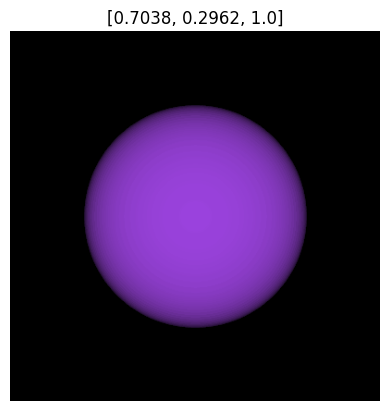

In [7]:
from train import graphing_sphere_train, sphere_train

# graphing_sphere_train(color_to_optimize, rays_origin, rays_direction, target_px_colors, optimizer, save_dir="test_img")
sphere_train(color_to_optimize, rays_origin, rays_direction, target_px_colors, optimizer, save_dir='test_img')